# Grid World --- past all grids
##### Charles Zhang
##### Jun 17

###  1. Cover and Get Back

In [1]:
import numpy as np

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 4
START = (0, 0)
END = (0, 0)

In [3]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def check_end(self):
        if self.state == END:
            self.is_end = True

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state

In [4]:
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]      # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.3
        self.exp_rate = 1
        self.decay_gamma = 0.9
        self.Q_values = {}             # init Q values (dict)
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        self.past_all = []
        for i in range(BOARD_ROWS):
            t = []
            for j in range(BOARD_COLS): 
                t.append(False)
            self.past_all.append(t)
        self.steps = []
    
    def optimal_action(self):
        max_value = -100
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        if np.random.uniform(0, 1) <= self.exp_rate:
            up = self.State.next_position("up")
            down = self.State.next_position("down")
            left = self.State.next_position("left")
            right = self.State.next_position("right")
            rule = [self.past_all[up[0]][up[1]] is True,
                    self.past_all[down[0]][down[1]] is True,
                    self.past_all[left[0]][left[1]] is True,
                    self.past_all[right[0]][right[1]] is True ]
            if all(rule):
                action = np.random.choice(self.actions)
                return action
            else:
                while True:
                    action = np.random.choice(self.actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] == False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()
    
    def give_reward(self):
        reward = 0
        if self.past_all[self.State.state[0]][self.State.state[1]] is False:
            reward += 1
        else:
            reward -= .1
        return reward
    
    def set_action(self, action):
        curr_state = self.State.state
        self.past_all[curr_state[0]][curr_state[1]] = True
        next_state = self.State.next_position(action)  
        self.State = State(state=next_state)
        reward = self.give_reward()
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
        if self.State.state==START and self.check_all_past():
            reward += 1
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:  
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha*(reward + self.decay_gamma*(max(qs_of_next_state)) -
                            self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action]+delta, 4)
        

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
    
    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True

    def train(self, rounds=100):
        print("Training...")
        for r in range(rounds): 
            self.reset()
            self.exp_rate *= 0.9
            step = 0
            while True:
                action = self.get_action()
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
                if (self.is_end == True) and (self.check_all_past() == True):
                # if self.check_all_past() == True:
                    break
            self.steps.append(step)
        print("Training finished!")

In [5]:
agent = Agent()
agent.train()

Training...
Training finished!


In [6]:
agent.Q_values

{(0, 0): {'down': 1.0277, 'left': 0.7958, 'right': 8.9293, 'up': 1.4952},
 (0, 1): {'down': 1.4871, 'left': 0.8678, 'right': 8.9279, 'up': 0.4393},
 (0, 2): {'down': 2.1858, 'left': 0.7125, 'right': 8.9267, 'up': 0.2259},
 (0, 3): {'down': 8.9252, 'left': 0.8987, 'right': 1.3987, 'up': 0.7264},
 (1, 0): {'down': 1.452, 'left': 1.3717, 'right': 1.9724, 'up': 8.8627},
 (1, 1): {'down': 8.8964, 'left': 1.9081, 'right': 0.4442, 'up': 0.4662},
 (1, 2): {'down': 1.3337, 'left': 8.9055, 'right': 1.2648, 'up': 0.3118},
 (1, 3): {'down': 8.9228, 'left': 3.1959, 'right': 0.5446, 'up': 0.9657},
 (2, 0): {'down': 1.5907, 'left': 0.3881, 'right': 1.3177, 'up': 8.8747},
 (2, 1): {'down': 0.193, 'left': 8.8861, 'right': 1.3519, 'up': 1.9171},
 (2, 2): {'down': 0.7823, 'left': 2.1356, 'right': 0.9649, 'up': 8.9131},
 (2, 3): {'down': 0.7721, 'left': 8.9188, 'right': 1.268, 'up': 0.6466}}

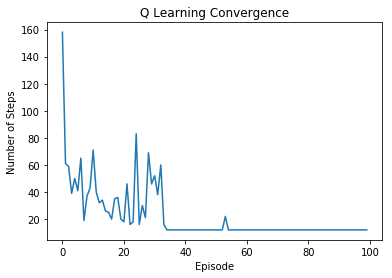

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(100):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [8]:
min(agent.steps)

12

### Optimal Policy

![](https://raw.githubusercontent.com/zcczhang/UAV_Coverage/master/Daily_Codes/Grid%20World/policy1.png)

### 2. If the connected graph does not have a Euler's Path

Training...
Training finished!


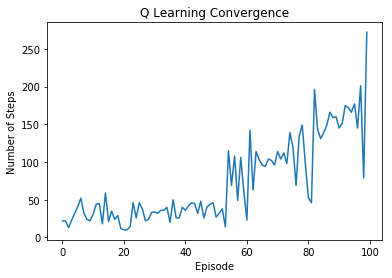

In [9]:
BOARD_ROWS = 3
BOARD_COLS = 3
START = (0, 0)
END = (0, 0)
agent = Agent()
agent.train()
x = []
for i in range(100):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

If I set up the restriction that the agent should come back once covered all grids, not surprisingly, values in Q tables are very closed. 

In [10]:
agent.Q_values

{(0, 0): {'down': -0.4627, 'left': -0.4697, 'right': -0.4728, 'up': -0.4706},
 (0, 1): {'down': -0.4766, 'left': -0.4632, 'right': -0.4624, 'up': -0.467},
 (0, 2): {'down': -0.4697, 'left': -0.4673, 'right': -0.4702, 'up': -0.4558},
 (1, 0): {'down': -0.4727, 'left': -0.4659, 'right': -0.4707, 'up': -0.177},
 (1, 1): {'down': -0.4737, 'left': -0.4759, 'right': -0.4627, 'up': -0.469},
 (1, 2): {'down': -0.4758, 'left': -0.4565, 'right': -0.4562, 'up': -0.4607},
 (2, 0): {'down': -0.4746, 'left': -0.4788, 'right': -0.4698, 'up': -0.4788},
 (2, 1): {'down': -0.4784, 'left': -0.4711, 'right': -0.4791, 'up': -0.4815},
 (2, 2): {'down': -0.4689, 'left': -0.4841, 'right': -0.4778, 'up': -0.479}}

In [11]:
min(agent.steps)

10

### 3. Task for only coverage not getting back

In [12]:
BOARD_ROWS = 3
BOARD_COLS = 3
START = (0, 0)
# END = (0, 0)

# only coverage not get back
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]      # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.3
        self.exp_rate = 1
        self.decay_gamma = 0.9
        self.Q_values = {}             # init Q values (dict)
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        self.past_all = []
        for i in range(BOARD_ROWS):
            t = []
            for j in range(BOARD_COLS): 
                t.append(False)
            self.past_all.append(t)
        self.steps = []
    
    def optimal_action(self):
        max_value = -100
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        if np.random.uniform(0, 1) <= self.exp_rate:
            up = self.State.next_position("up")
            down = self.State.next_position("down")
            left = self.State.next_position("left")
            right = self.State.next_position("right")
            rule = [self.past_all[up[0]][up[1]] is True,
                    self.past_all[down[0]][down[1]] is True,
                    self.past_all[left[0]][left[1]] is True,
                    self.past_all[right[0]][right[1]] is True ]
            if all(rule):
                action = np.random.choice(self.actions)
                return action
            else:
                while True:
                    action = np.random.choice(self.actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] == False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()
    
    def give_reward(self):
        reward = 0
        if self.past_all[self.State.state[0]][self.State.state[1]] is False:
            reward += 1
        else:
            reward -= .1
        return reward
    
    def set_action(self, action):
        curr_state = self.State.state
        self.past_all[curr_state[0]][curr_state[1]] = True
        next_state = self.State.next_position(action)  
        self.State = State(state=next_state)
        reward = self.give_reward()
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
#         if self.State.state==START and self.check_all_past():
#             reward += 1
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:  
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha*(reward + self.decay_gamma*(max(qs_of_next_state)) -
                            self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action]+delta, 4)
        

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
    
    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True

    def train(self, rounds=100):
        print("Training...")
        for r in range(rounds): 
            self.reset()
            self.exp_rate *= 0.9
            step = 0
            while True:
                action = self.get_action()
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
                #if (self.is_end == True) and (self.check_all_past() == True):
                if self.check_all_past() == True:
                    break
            self.steps.append(step)
        print("Training finished!")

Training...
Training finished!


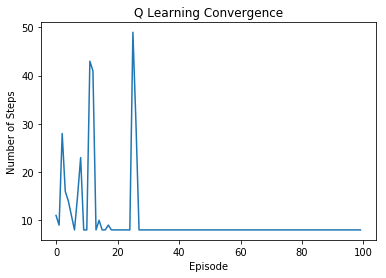

In [13]:
agent = Agent()
agent.train()
x = []
for i in range(100):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [14]:
agent.Q_values

{(0, 0): {'down': 0.8391, 'left': 0.407, 'right': 6.4529, 'up': 1.1228},
 (0, 1): {'down': 1.8532, 'left': 0.2433, 'right': 6.0589, 'up': 0},
 (0, 2): {'down': 5.6211, 'left': 0, 'right': 0, 'up': 0},
 (1, 0): {'down': 0.6106, 'left': 0.3498, 'right': 2.5851, 'up': 1.5134},
 (1, 1): {'down': 1.7613, 'left': 0.8955, 'right': 1.1119, 'up': 0.8617},
 (1, 2): {'down': 5.1347, 'left': 1.1717, 'right': -0.03, 'up': 1.179},
 (2, 0): {'down': 0.808, 'left': 0.4317, 'right': 0, 'up': 3.3265},
 (2, 1): {'down': 0.8125, 'left': 3.9937, 'right': 1.7262, 'up': 1.6228},
 (2, 2): {'down': 0.6746, 'left': 4.5942, 'right': 0.3717, 'up': 1.1587}}

In [15]:
min(agent.steps)

8

### Optimal  Policy

![](https://raw.githubusercontent.com/zcczhang/UAV_Coverage/master/Daily_Codes/Grid%20World/policy2.jpeg)